### prep

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.dont_write_bytecode = True

In [2]:
#imports
import os
import yaml
import json
import warnings
from itertools import product

import mlflow

import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score
from sklearn.metrics import recall_score
import numpy as np
from datetime import datetime

from callables import parse_json
from callables import generate_features
from callables import process_features
from callables import model_train
from utils import plot_roc_curve, plot_confusion_matrix, plot_feature_importnaces, find_max_fscore 

warnings.filterwarnings('ignore')

In [3]:
#params
with open("params.yml", 'r') as file:
    params = yaml.safe_load(file)

root_path = params['root_path']
filepath_input = root_path + params['filepath_input']
model_name = params['model_name']

feature_cols = params['feature_cols']

shift_backwards = 5
shift_forward = -5

anomaly_crtiretion = params['anomaly_crtiretion']

cb_params = params['cb_params']

In [4]:
#read
df = parse_json(filepath_input)
df = generate_features(
    df, feature_cols,
    shift_backwards, shift_forward, 
    anomaly_crtiretion
)
df_event, df_period, df_model = process_features(df, feature_cols)

#### plots

### v0 - все

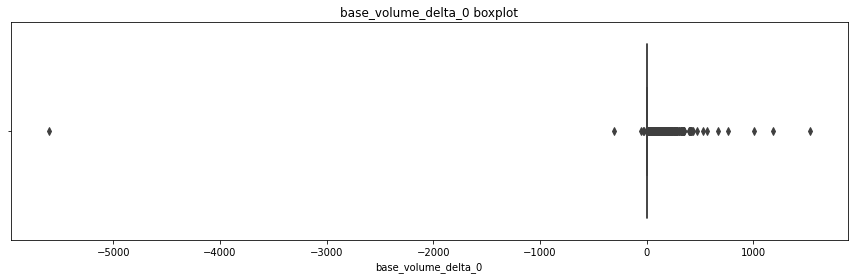

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize = (15,4))
sns.boxplot(df_model['base_volume_delta_0'])
plt.title("base_volume_delta_0 boxplot")
plt.show()

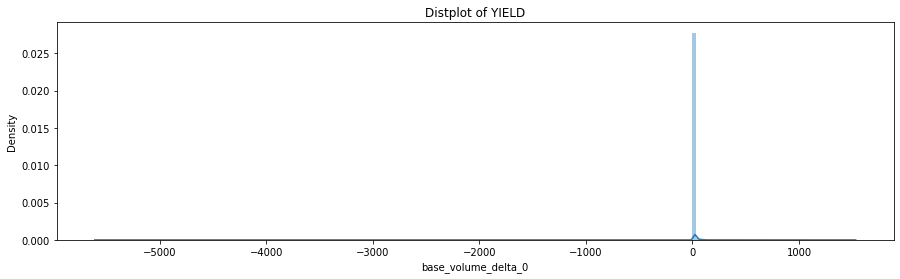

In [6]:
#plot params
plt.figure(figsize = (15,4))
sns.distplot(df_model['base_volume_delta_0'],bins = 200)
plt.title(f'Distplot of YIELD')
plt.show()

### v1 - масса основная

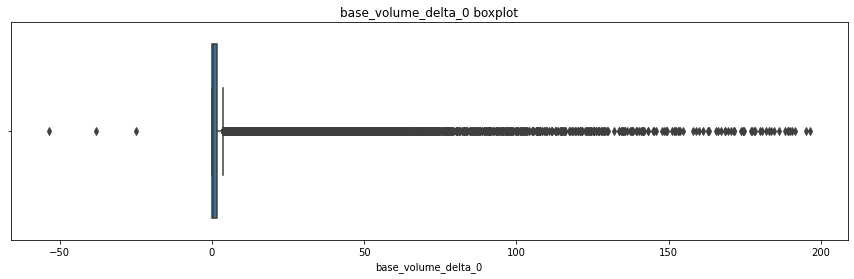

In [7]:
low = -200
up = 200

df_boxplot = df_model[(df_model['base_volume_delta_0'] > low) &
                      (df_model['base_volume_delta_0'] < up)].copy()



plt.figure(figsize = (15,4))
sns.boxplot(df_boxplot['base_volume_delta_0'])
plt.title("base_volume_delta_0 boxplot")
plt.show()

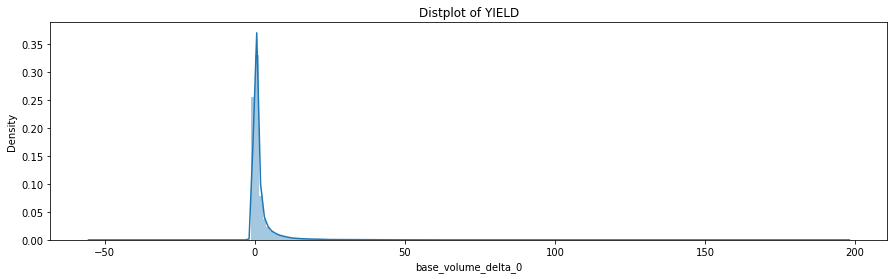

In [8]:
df_distplot = df_model[(df_model['base_volume_delta_0'] > low) &
                       (df_model['base_volume_delta_0'] < up)].copy()

plt.figure(figsize = (15,4))
sns.distplot(df_distplot['base_volume_delta_0'],bins = 200)
plt.title(f'Distplot of YIELD')
plt.show()

### v2 - аномальные

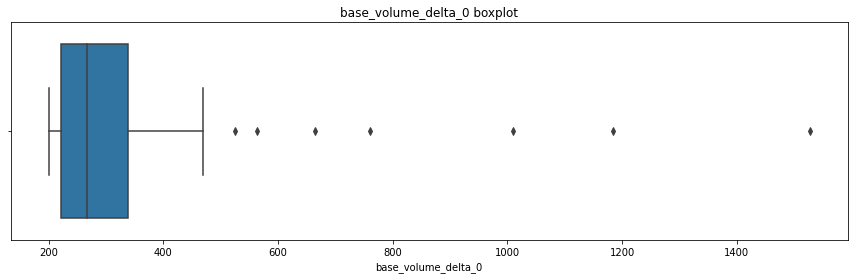

In [9]:
low = 200
up = np.inf

df_boxplot = df_model[(df_model['base_volume_delta_0'] > low) &
                      (df_model['base_volume_delta_0'] < up)].copy()



plt.figure(figsize = (15,4))
sns.boxplot(df_boxplot['base_volume_delta_0'])
plt.title("base_volume_delta_0 boxplot")
plt.show()

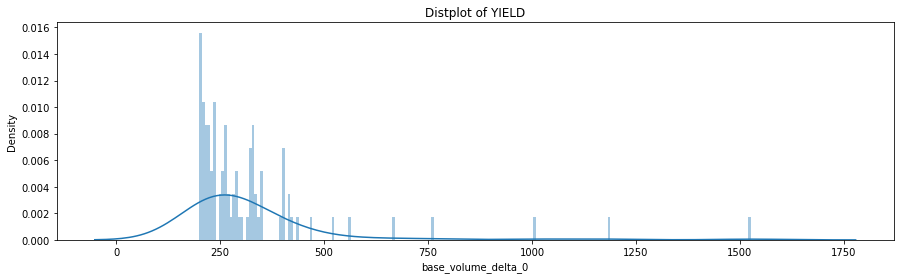

In [10]:
df_distplot = df_model[(df_model['base_volume_delta_0'] > low) &
                       (df_model['base_volume_delta_0'] < up)].copy()

plt.figure(figsize = (15,4))
sns.distplot(df_distplot['base_volume_delta_0'],bins = 200)
plt.title(f'Distplot of YIELD')
plt.show()

### model

### v0 - все

In [11]:
#split
train, test = train_test_split(df_model, test_size = 0.2, random_state = 42, shuffle = False)

x_train = train.drop('target', axis = 1)
y_train = train.target.astype(int)

x_test = test.drop('target', axis = 1)
y_test = test.target.astype(int)

#fit best model
model = CatBoostClassifier(**cb_params)
model.fit(x_train, y_train)

# predict train probabilities
y_train_pred_proba = model.predict_proba(x_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

# predict test probabilities
y_test_pred_proba = model.predict_proba(x_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

#opt_cutoff
opt_cutoff = find_max_fscore(y_test, y_test_pred_proba)

#calculate metrics
f1_score_train = f1_score(y_train, (y_train_pred_proba > opt_cutoff), pos_label=1, average='binary')
f1_score_test  = f1_score(y_test , (y_test_pred_proba  > opt_cutoff), pos_label=1, average='binary')

#display metrics
metrics_df = pd.DataFrame({'f1_score_train':[f1_score_train],
                           'f1_score_test':[f1_score_test]})

display(metrics_df)

,f1_score_train,f1_score_test
0,0.365164,0.371257


### v1 - основаня масса

In [18]:
low = -500
up = 500

df_test  = df_model[(df_model['base_volume_delta_0'] > low) &
                    (df_model['base_volume_delta_0'] < up)].copy()

len(df_test)
print('Доля от общей выборки:', round(100 * len(df_test)/len(df_model),2))

#split
train, test = train_test_split(df_test, test_size = 0.2, random_state = 42, shuffle = False)

x_train = train.drop('target', axis = 1)
y_train = train.target.astype(int)

x_test = test.drop('target', axis = 1)
y_test = test.target.astype(int)

#fit best model
model = CatBoostClassifier(**cb_params)
model.fit(x_train, y_train)

# predict train probabilities
y_train_pred_proba = model.predict_proba(x_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

# predict test probabilities
y_test_pred_proba = model.predict_proba(x_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

#opt_cutoff
opt_cutoff = find_max_fscore(y_test, y_test_pred_proba)

#calculate metrics
f1_score_train = f1_score(y_train, (y_train_pred_proba > opt_cutoff), pos_label=1, average='binary')
f1_score_test  = f1_score(y_test , (y_test_pred_proba  > opt_cutoff), pos_label=1, average='binary')

#display metrics
metrics_df = pd.DataFrame({'f1_score_train':[f1_score_train],
                           'f1_score_test':[f1_score_test]})

display(metrics_df)

Доля от общей выборки: 100.0


,f1_score_train,f1_score_test
0,0.361832,0.385542


### v2 - аномальные

In [16]:
low = 200
up = np.inf

df_test  = df_model[(df_model['base_volume_delta_0'] > low) &
                    (df_model['base_volume_delta_0'] < up)].copy()

len(df_test)
print('Доля от общей выборки:', round(100 * len(df_test)/len(df_model),2))

#split
train, test = train_test_split(df_test, test_size = 0.2, random_state = 42, shuffle = False)

x_train = train.drop('target', axis = 1)
y_train = train.target.astype(int)

x_test = test.drop('target', axis = 1)
y_test = test.target.astype(int)

#fit best model
model = CatBoostClassifier(**cb_params)
model.fit(x_train, y_train)

# predict train probabilities
y_train_pred_proba = model.predict_proba(x_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

# predict test probabilities
y_test_pred_proba = model.predict_proba(x_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

#opt_cutoff
opt_cutoff = find_max_fscore(y_test, y_test_pred_proba)

#calculate metrics
f1_score_train = f1_score(y_train, (y_train_pred_proba > opt_cutoff), pos_label=1, average='binary')
f1_score_test  = f1_score(y_test , (y_test_pred_proba  > opt_cutoff), pos_label=1, average='binary')

#display metrics
metrics_df = pd.DataFrame({'f1_score_train':[f1_score_train],
                           'f1_score_test':[f1_score_test]})

display(metrics_df)

Доля от общей выборки: 0.04


,f1_score_train,f1_score_test
0,0.207792,0.0
